In [10]:
import numpy 
import pandas as pd
import psycopg2 as pg
import criador as criador
import datetime
from matplotlib import pyplot as plt

In [4]:
usuario = "csk"
senha = "csk123"

filePath = 'dados_covid.csv'

db = criador.connectDatabase()
cursor = db.cursor()

dadosCovid = pd.read_csv( filePath )
filtro_cidades = (dadosCovid['city'] == 'Joinville') | (dadosCovid['city'] == 'Francisco Beltrão') | (dadosCovid['city'] == 'Dois Vizinhos') | (dadosCovid['city'] == 'Pato Branco') | (dadosCovid['city'] == 'Florianópolis')
dadosCovid = dadosCovid[filtro_cidades]

cidades = dadosCovid.drop_duplicates( 'city' )

In [5]:
def postgresql_to_dataframe(conn, select_query, column_names):
    """
    Tranform a SELECT query into a pandas dataframe
    """
    cursor = conn.cursor()
    try:
        cursor.execute(select_query)
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        cursor.close()
        return 1
    
    # Naturally we get a list of tupples
    tupples = cursor.fetchall()
    cursor.close()
    
    # We just need to turn it into a pandas dataframe
    df = pd.DataFrame(tupples, columns=column_names)
    return df

In [7]:
# Connect to the database
conn = criador.connectDatabase()

column_names_cidade = ["codigo_ibge", "nome_cidade", "estado", "numero_habitantes"]
# Execute the "SELECT *" query
df_cidades = postgresql_to_dataframe(conn, "select * from cidade", column_names_cidade)

In [9]:
column_names_contagio = ["codigo_ibge", "data_registro", "total_casos_confirmados", "novos_casos_confirmados", "total_mortes", "novas_mortes"]
# Execute the "SELECT *" query
df_contagio = postgresql_to_dataframe(conn, "select * from contagio", column_names_contagio)

In [12]:
column_names_juncao = ["codigo_ibge", "nome_cidade", "estado","data_registro", "total_casos_confirmados", "novos_casos_confirmados", "total_mortes", "novas_mortes"]
query = """SELECT
                con.codigo_ibge,
                cid.nome_cidade,
                cid.estado,
                con.data_registro,
                con.total_casos_confirmados,
                con.novos_casos_confirmados,
                con.total_mortes,
                con.novas_mortes
            FROM contagio con
            LEFT JOIN cidade cid
                ON cid.codigo_ibge = con.codigo_ibge
            ORDER BY
                con.codigo_ibge, con.data_registro;
        """

df_juncao = postgresql_to_dataframe(conn, query, column_names_juncao)

In [13]:
#separando os DF's de cada cidade
cols = ['nome_cidade', 'data_registro', 'total_casos_confirmados']
df_DV = df_juncao[df_juncao['nome_cidade'] == 'Dois Vizinhos'][cols]
df_JOIN = df_juncao[df_juncao['nome_cidade'] == 'Joinville'][cols]
df_FLORIPA = df_juncao[df_juncao['nome_cidade'] == 'Florianópolis'][cols]
df_PB = df_juncao[df_juncao['nome_cidade'] == 'Pato Branco'][cols]
df_FB = df_juncao[df_juncao['nome_cidade'] == 'Francisco Beltrão'][cols]

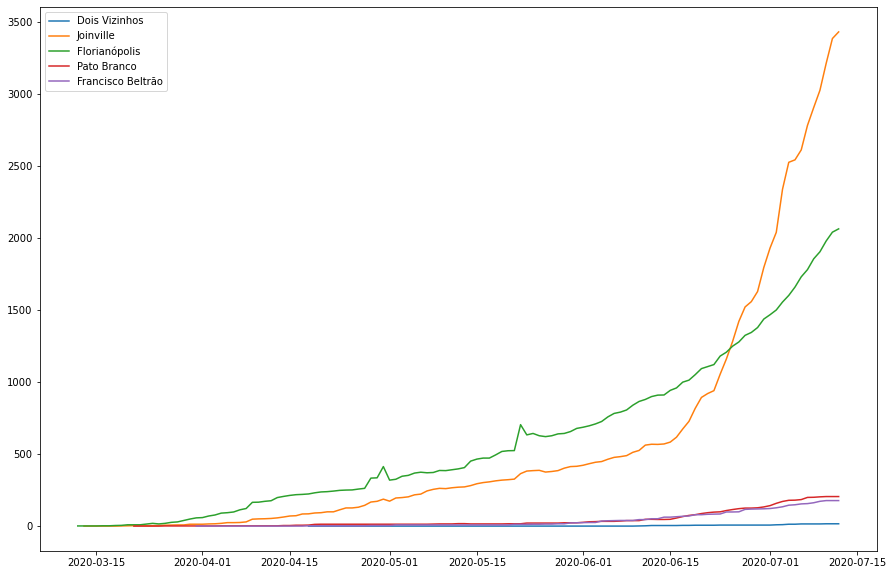

In [11]:
#plotando os gráficos de casos
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.plot(df_DV['data_registro'], df_DV['total_casos_confirmados'], label='Dois Vizinhos')
ax.plot(df_JOIN['data_registro'], df_JOIN['total_casos_confirmados'], label='Joinville')
ax.plot(df_FLORIPA['data_registro'], df_FLORIPA['total_casos_confirmados'], label='Florianópolis')
ax.plot(df_PB['data_registro'], df_PB['total_casos_confirmados'], label='Pato Branco')
ax.plot(df_FB['data_registro'], df_FB['total_casos_confirmados'], label='Francisco Beltrão')
ax.legend(loc='upper left')

In [14]:
numHabFlorianopolis = df_cidades.numero_habitantes.iloc[0]
numHabJoinville = df_cidades.numero_habitantes.iloc[1]
numHabPatoBranco = df_cidades.numero_habitantes.iloc[2]
numHabFranciscoBeltrao = df_cidades.numero_habitantes.iloc[3]
numHabDoisVizinhos = df_cidades.numero_habitantes.iloc[4]

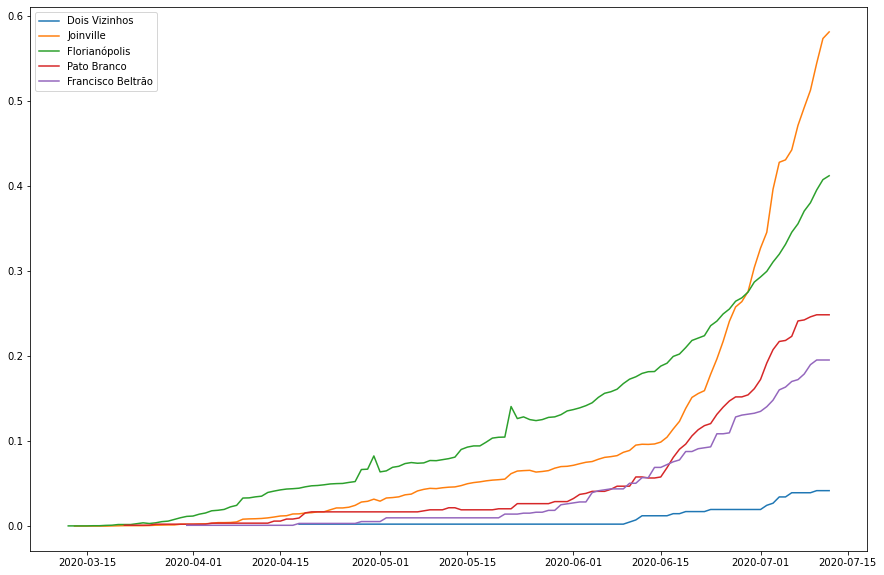

In [15]:
#plotando os gráficos casos relativos com sua população
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.plot(df_DV['data_registro'], df_DV['total_casos_confirmados']/numHabDoisVizinhos*100, label='Dois Vizinhos')
ax.plot(df_JOIN['data_registro'], df_JOIN['total_casos_confirmados']/numHabJoinville*100, label='Joinville')
ax.plot(df_FLORIPA['data_registro'], df_FLORIPA['total_casos_confirmados']/numHabFlorianopolis*100, label='Florianópolis')
ax.plot(df_PB['data_registro'], df_PB['total_casos_confirmados']/numHabPatoBranco*100, label='Pato Branco')
ax.plot(df_FB['data_registro'], df_FB['total_casos_confirmados']/numHabFranciscoBeltrao*100, label='Francisco Beltrão')
ax.legend(loc='upper left')

In [ ]:
#O gráfico nos mostra a relação de casos confirmados por total de habitantes de cada cidade respectivamente.

#Quais cidades devem ter prioridade na alocação de recursos para o combate à COVID19?
#   Com o gráfico fica fácil ver a inclinação da taxa referente a Joinville e Florianópolis.
#   Joinville e Florianópolis devem ter prioridades na alocação de recursos.

#Qual o nível de risco de cada cidade?
#   Igualmente a resposta anterior, fica nítido que as duas cidades que estão em rítimo de crescimento vertiginoso (Joinville e Florianópolis)
#   devem receber o maior nível de risco
#   As outras três cidades (Dois Vizinhos, Pato Branco e Francisco Beltrão) estão chegando em algo similar a um platô onde se tem um maior controle
#   da transmissibilidade do vírus.

In [16]:
filtro_df_juncao = (df_juncao['data_registro'] == datetime.date(2020,7,12))
df_ultimo_dia = df_juncao[filtro_df_juncao]

In [18]:
numHabUDDoisVizinhos = df_ultimo_dia.total_casos_confirmados.iloc[0]
numHabUDFranciscoBeltrao = df_ultimo_dia.total_casos_confirmados.iloc[1]
numHabUDPatoBranco = df_ultimo_dia.total_casos_confirmados.iloc[2]
numHabUDFlorianopolis = df_ultimo_dia.total_casos_confirmados.iloc[3]
numHabUDJoinville = df_ultimo_dia.total_casos_confirmados.iloc[4]

In [19]:
PropDoisVizinhos = df_ultimo_dia.total_casos_confirmados.iloc[0]/numHabDoisVizinhos*100
PropFranciscoBeltrao = df_ultimo_dia.total_casos_confirmados.iloc[1]/numHabFranciscoBeltrao*100
PropPatoBranco = df_ultimo_dia.total_casos_confirmados.iloc[2]/numHabPatoBranco*100
PropFlorianopolis = df_ultimo_dia.total_casos_confirmados.iloc[3]/numHabFlorianopolis*100
PropJoinville = df_ultimo_dia.total_casos_confirmados.iloc[4]/numHabJoinville*100
somaProp = PropDoisVizinhos + PropFranciscoBeltrao + PropPatoBranco + PropFlorianopolis + PropJoinville

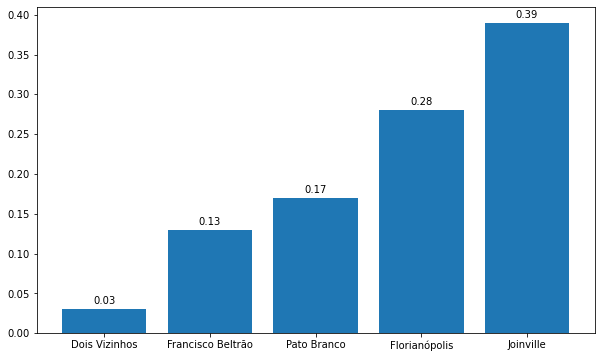

In [20]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
n1 = numpy.round_(PropDoisVizinhos/somaProp,2)
n2 = numpy.round_(PropFranciscoBeltrao/somaProp,2)
n3 = numpy.round_(PropPatoBranco/somaProp,2)
n4 = numpy.round_(PropFlorianopolis/somaProp,2)
n5 = numpy.round_(PropJoinville/somaProp,2)
X = [n1, n2, n3, n4, n5]
Y = ['Dois Vizinhos', 'Francisco Beltrão', 'Pato Branco', 'Florianópolis', 'Joinville']
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
rects1 = ax.bar(Y, X)
autolabel(rects1)

In [21]:
#Qual proporção dos recursos cada cidade deve receber?
#   Tendo em vista os dados de somente essas cinco cidades, os recursos devem ser divididos nas seguintes proporções:
#   1ª Joinville com 39% dos recursos
#   2ª Florianópolis com 28% dos recursos
#   3ª Pato Branco com 17% dos recursos
#   4ª Francisco Beltrão com 13% dos recursos
#   5ª Dois Vizinhos com 3% dos recursos